In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LinearRegression

In [16]:
# Import annual hate crime offenses table
years = np.linspace(2005, 2020, 16, dtype=int).tolist()
offenses =[]
for y in years:
    n = y - 2005
    offenses_path='./offenses_csv/%s.csv'%(y)
    offenses.append(pd.read_csv(offenses_path, thousands=','))
    # Add Year column
    offenses[n]['Year'] = y

# Aombine all years' offenses data
table_off = pd.concat(offenses)
# Drop details because we only care about total
table_off = table_off[table_off['Agency type'] == 'Total']
table_off = table_off.drop(columns=['Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17',
                                    '1st\r\nquarter', '2nd\r\nquarter', '3rd\r\nquarter', '4th\r\nquarter', 'Agency name', 'Agency type',
                                    'Unnamed: 3', 'Unnamed: 9', 'No. of\r\nquarters\r\nreported', 'Agency unit', 'Population1'])
# Replace NaN with zeros
table_off = table_off.replace(np.nan,0)
# Replace exisiting str zero with float
cat_list=['Race', 'Religion', 'Sexual_orientation', 'Ethnicity', 'Disability', 'Gender', 'Gender_identity', 'Race/Ethnicity/Ancestry']
table_off[cat_list] = table_off[cat_list].astype(float)
# Add up total offenses
table_off['Offenses'] = table_off['Religion'] + table_off['Sexual_orientation'] + table_off['Ethnicity'] + table_off['Disability']
+ table_off['Gender'] + table_off['Gender_identity'] + table_off['Race/Ethnicity/Ancestry'] +table_off['Race'] + table_off['Ethnicity']
# Get rid of categories because we only care about total
table_off = table_off.drop(columns=cat_list)

# Normalize State format
table_off['State'] = table_off['State'].str.capitalize()
table_off['Year'] = table_off['Year'].astype(str)
table_off = table_off.reset_index(drop=True)
table_off

,Year,State,Offenses
0,2006,Alabama,0.0
1,2006,Alaska,2.0
2,2006,Arizona,97.0
3,2006,Arkansas,22.0
4,2006,California,700.0
...,...,...,...
742,2020,Virginia,46.0
743,2020,Washington,124.0
744,2020,West virginia,21.0
745,2020,Wisconsin,24.0


In [17]:
pop1 = pd.read_csv('./pop1.csv', thousands=',')
# Trun wide df to tidy
pop1 = pd.melt(pop1, id_vars=['State'], value_vars=pop1.columns[1:], var_name='Year', value_name='Population')
pop1

,State,Year,Population
0,Alabama,2010,4779736
1,Alaska,2010,710231
2,Arizona,2010,6392017
3,Arkansas,2010,2915918
4,California,2010,37253956
...,...,...,...
567,Washington,2020,7693612
568,West Virginia,2020,1784787
569,Wisconsin,2020,5832655
570,Wyoming,2020,582328


In [18]:
pop2 = pd.read_csv('./pop2.csv', thousands=',')

# Select totol by setting all categorical inputs to zero
pop2 = pop2[pop2['SEX'] == 0]
pop2 = pop2[pop2['ORIGIN'] == 0]
pop2 = pop2[pop2['RACE'] == 0]
pop2 = pop2[pop2['AGEGRP'] == 0]

pop2 = pop2.drop(columns=['SEX', 'ORIGIN', 'RACE', 'AGEGRP'])
# Trun wide df to tidy
pop2 = pd.melt(pop2, id_vars=['State'], value_vars=pop2.columns[1:], var_name='Year', value_name='Population')
pop2

,State,Year,Population
0,Alabama,2000,4447207
1,Alaska,2000,626933
2,Arizona,2000,5130247
3,Arkansas,2000,2673293
4,California,2000,33871653
...,...,...,...
505,Virginia,2009,7925937
506,Washington,2009,6667426
507,West Virginia,2009,1847775
508,Wisconsin,2009,5669264


In [19]:
# combine pop data (2010-2020) and (2000-2009)
table_pop = pd.concat([pop2, pop1])
table_pop

,State,Year,Population
0,Alabama,2000,4447207
1,Alaska,2000,626933
2,Arizona,2000,5130247
3,Arkansas,2000,2673293
4,California,2000,33871653
...,...,...,...
567,Washington,2020,7693612
568,West Virginia,2020,1784787
569,Wisconsin,2020,5832655
570,Wyoming,2020,582328


In [20]:
table_gdp = pd.read_csv('./gdp.csv', thousands=',')
# Trun wide df to tidy
table_gdp = pd.melt(table_gdp, id_vars=['State'], value_vars=table_gdp.columns[1:], var_name='Year', value_name='GDP')
table_gdp

,State,Year,GDP
0,Alabama,1998,149568.2
1,Alaska,1998,41095.9
2,Arizona,1998,183060.5
3,Arkansas,1998,84570.8
4,California,1998,1468730.8
...,...,...,...
1219,Virginia,2021,505351.0
1220,Washington,2021,575129.0
1221,West Virginia,2021,71343.2
1222,Wisconsin,2021,306467.4


In [21]:
# Combine all input features and the output
table = table_pop.merge(table_gdp, on=['State', 'Year'])
table = table.merge(table_off, on=['State', 'Year'])
table['Year'] = table['Year'].astype(int)
table

,State,Year,Population,GDP,Offenses
0,Alabama,2006,4628981,187270.8,0.0
1,Alaska,2006,675302,49190.2,2.0
2,Arizona,2006,6029141,274179.4,97.0
3,Arkansas,2006,2821761,108460.6,22.0
4,California,2006,36021202,2002437.4,700.0
...,...,...,...,...,...
576,Vermont,2020,623347,29064.6,18.0
577,Virginia,2020,8590563,478909.3,46.0
578,Washington,2020,7693612,538856.1,124.0
579,Wisconsin,2020,5832655,293104.9,24.0


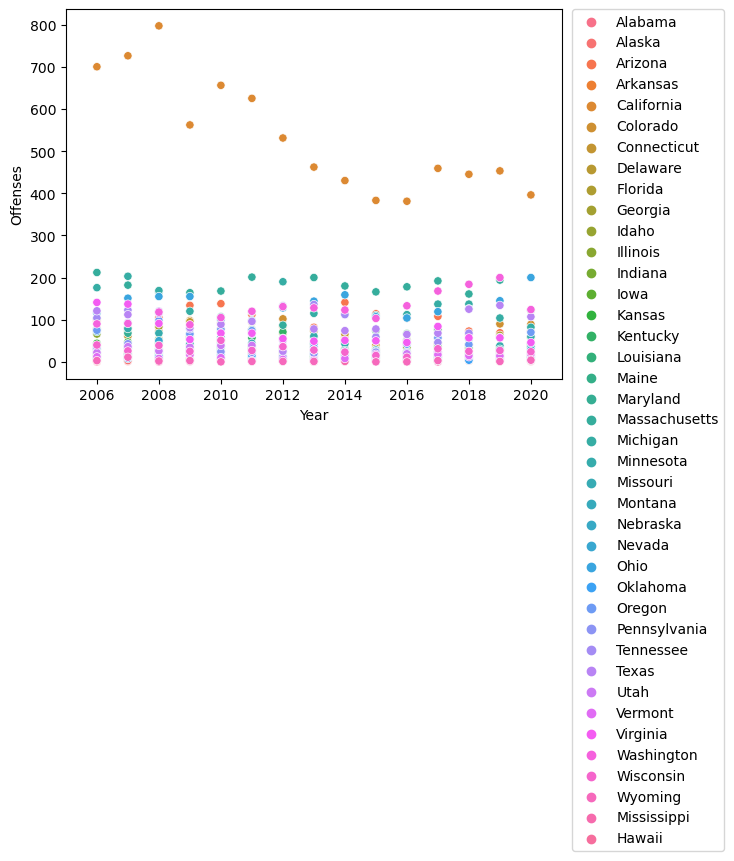

In [22]:
# Plot scatter plot Offenses X Year
ax = sns.scatterplot(data=table, x='Year', y='Offenses', hue='State')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
ax.set_xlim(2005,2021)
plt.show()

In [23]:
# Print reg model variables, coefficient, and intercept
def run_regression(input, train, test, output):
    X_train = train[input]
    X_test = test[input]
    y_train = train[output]
    y_test = test[output]
    reg = LinearRegression().fit(X_train, y_train)
    pred_train = reg.predict(X_train)
    pred_test = reg.predict(X_test)

    print('variables: '+str(input))
    print('coefficient: '+str(reg.coef_))
    print('intercept: '+str(reg.intercept_))
    print(' ')

In [24]:
# single-variable models and all-variable model
input = ['Year', 'Population', 'GDP']
output = 'Offenses'
test = table[(table['Year'] == 2020) | (table['Year'] == 2019)]
train = table[(table['Year'] != 2020) & (table['Year'] != 2019)]

for i in input:
    run_regression([i], train, test, output)

run_regression(input, train, test, output)

variables: ['Year']
coefficient: [-2.21136234]
intercept: 4507.850660323789
 
variables: ['Population']
coefficient: [9.56324813e-06]
intercept: -5.765956351960604
 
variables: ['GDP']
coefficient: [0.00017491]
intercept: -1.9910328331773073
 
variables: ['Year', 'Population', 'GDP']
coefficient: [-3.54481159e+00 -8.50093458e-06  3.25297132e-04]
intercept: 7135.292653990261
 


In [25]:
# Plot output~one input groupy by State
def plot_single(df, input):
    sns.lmplot(x=input, y='Offenses', data=df, hue='State')
    plt.show()

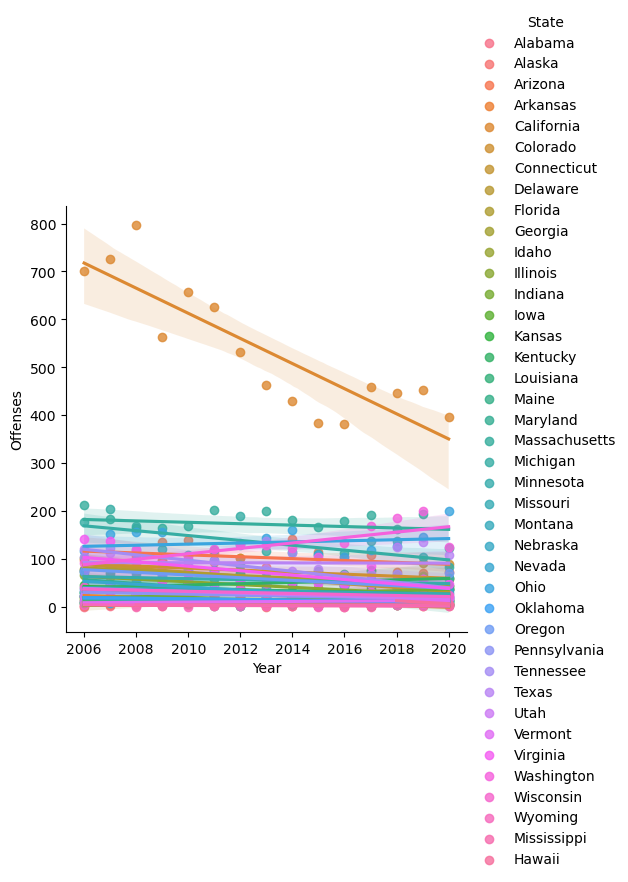

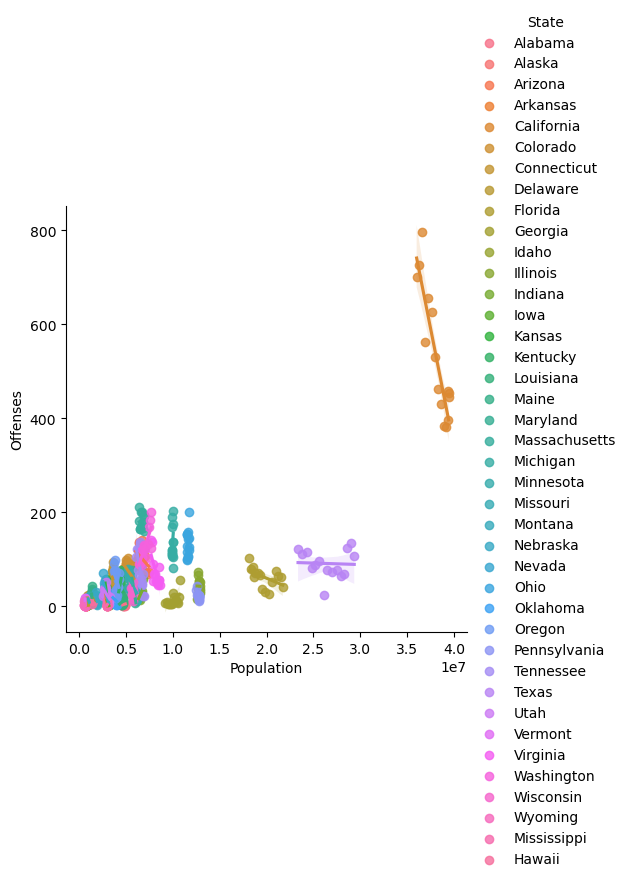

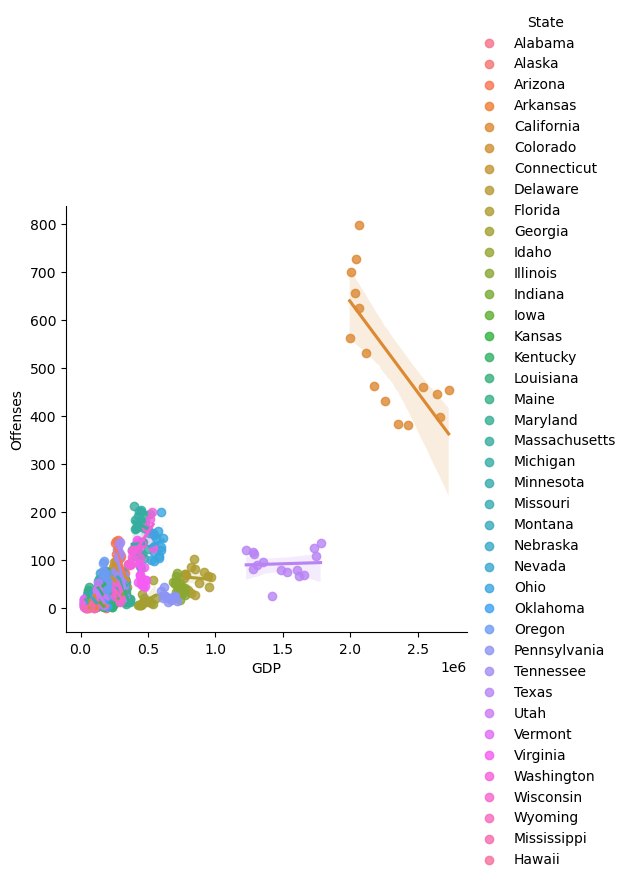

In [26]:
# Plot each input
for i in input:
    plot_single(table, i)